### 1. データを準備

In [1]:
import glob
import pandas as pd
import json
from datetime import datetime as dt

### 引用ペアデータ(データ①)

In [3]:
#論文のデータ①を見る
df_citation=pd.read_csv("aps_data/aps-dataset-citations-2020.csv")
df_citation.head()

,citing_doi,cited_doi
0,10.1103/PhysRevSeriesI.11.215,10.1103/PhysRevSeriesI.1.1
1,10.1103/PhysRevSeriesI.12.121,10.1103/PhysRevSeriesI.1.166
2,10.1103/PhysRevSeriesI.7.93,10.1103/PhysRevSeriesI.1.166
3,10.1103/PhysRevSeriesI.16.267,10.1103/PhysRevSeriesI.2.35
4,10.1103/PhysRevSeriesI.17.65,10.1103/PhysRevSeriesI.2.112


### 論文詳細データ(データ②)

In [4]:
#論文のデータ②の1つのファイルを見る
#issue:号 volume:巻
json_open = open("aps_data/aps-dataset-metadata-2020/PRI/11/PhysRevSeriesI.11.215.json", "r",encoding="utf-8")
json_load = json.load(json_open)
json_load["id"]

'10.1103/PhysRevSeriesI.11.215'

### すべての論文とその投稿年を表すデータフレームを新たに作成(データ③)

In [5]:
id_lis=[]#idリスト
date_lis=[]#投稿年リスト

folder_journal = glob.glob("aps_data/aps-dataset-metadata-2020/*")#metaすべてのフォルダリスト

for journal in folder_journal:
    folder_issue=glob.glob(journal+"/*")
    
    for issue in folder_issue:
        file_json=glob.glob(issue+"/*")
        
        for file in file_json:
            json_open = open(file, "r",encoding="utf-8")
            json_load = json.load(json_open)
            each_id=json_load["id"]
            each_date=dt.strptime(json_load["date"], '%Y-%m-%d')
            if dt(1980, 1, 1) <= each_date <=  dt(2020, 12, 31):
                id_lis.append(each_id)
                date_lis.append(each_date.strftime("%Y-%m-%d"))
                
df_data3=pd.DataFrame(list(zip(id_lis,date_lis)), columns=["id","year"])
df_data3.to_csv("aps-id-year.csv")

In [6]:
df_ID_year=pd.read_csv("aps-id-year.csv", index_col=0)
df_ID_year.head()

,id,year
0,10.1103/PhysRevA.100.010101,2019-07-11
1,10.1103/PhysRevA.100.010102,2019-07-26
2,10.1103/PhysRevA.100.010301,2019-07-22
3,10.1103/PhysRevA.100.010302,2019-07-31
4,10.1103/PhysRevA.100.010501,2019-07-11


### 2. データ処理

###  PRBで1980年に投稿された全論文の引用推移データフレームを作成 ###

In [7]:
#まずデータ②のPRBフォルダから1980に投稿され論文リストを作成する。
volumes=list(range(1, 103, 1)) #フォルダが1～102まであるため手動で設定
papers_PRB_1980=[]

for volume in volumes:
    files = glob.glob("aps_data/aps-dataset-metadata-2020/PRB/"+str(volume)+"/*")#PRBのフォルダリスト
    for file in files:
        json_open = open(file, "r",encoding="utf-8")
        json_load = json.load(json_open)
        tdatetime = dt.strptime(json_load["date"], '%Y-%m-%d')
        
        if dt(1980, 1, 1) <= tdatetime <=  dt(1980, 12, 31):
            papers_PRB_1980.append(json_load["id"])
            #print(json_load["id"])
len(papers_PRB_1980)

1415

In [8]:
#paper_PRB_1980を引用した論文リスト(多重)を作成する(データ①を用いて)
citing_year_lis=[]
cited_sum=0

for paper in papers_PRB_1980:
    df_PRB_1980=df_citation[df_citation['cited_doi']==paper] #データ①から被引用論文を抽出
    #import pdb; pdb.set_trace()
    df_PRB_1980_citing=df_PRB_1980[df_PRB_1980["citing_doi"].str.contains("PhysRevB")] #PRBからの引用に絞る
                
    if len(df_PRB_1980_citing) != 0:#何かしらPRB同士の引用がある場合
        cited_sum+=1
        for i in df_PRB_1980_citing["citing_doi"].values.tolist():
            year=df_ID_year[df_ID_year['id']==i]["year"].values.tolist()#引用した論文の投稿年をデータ③(2003年まで)で調べる
            if len(year) !=0:#2020年までの引用がある場合
                citing_year_lis.append(year[0])
            else:#2021年の論文は提供されたメタデータにそもそもない。
                #print(i+"はデータ③に含まれませんでした")
                pass

In [10]:
df_date=pd.DataFrame({"year": pd.date_range(start='01/01/1980', end='12/31/2020', freq='D')})#出版日から日ごとの日
df_date["cited_count"]=0#0の列を追加
df_date=df_date.set_index("year")#インデックスが年月日 、"count"列がすべての0のdfが完成

for date in citing_year_lis:
    count=df_date.loc[date]["cited_count"]#[first_citation]#引用された時刻のcount列を抽出
    df_date.loc[date]["cited_count"]=count+1
df_date_all=df_date.resample("6MS").sum()/cited_sum#ここで初めて半期ごとにリサンプリング(合計を計測)

In [11]:
df_date_all.head()

,cited_count
year,
1980-01-01,0.055465
1980-07-01,0.167210
1981-01-01,0.369494
1981-07-01,0.553834
1982-01-01,0.553018


### 引用に重みをつける前処理 ###

In [12]:
#まずPRBが6か月ごとに発行する論文数の推移を見る。
volumes=list(range(1, 103, 1)) #フォルダが1～125まであるため手動で設定
papers_PRB=[]

for volume in volumes:
    
    files = glob.glob("aps_data/aps-dataset-metadata-2020/PRB/"+str(volume)+"/*")#PRBのフォルダリスト
    
    for file in files:
        json_open = open(file, "r",encoding="utf-8")
        json_load = json.load(json_open)
        papers_PRB.append(json_load["id"])
        #print(json_load["id"])
len(papers_PRB)#PRBに投稿されたすべての論文リスト

197564

In [13]:
#インフレのデータフレームを作成

df_PRB=df_ID_year[df_ID_year["id"].isin(papers_PRB)]

df_I=pd.DataFrame({"year": pd.date_range(start='01/01/1980', end='12/31/2020', freq='D')})#出版日から日ごとの日
df_I["PRB_count"]=0#0の列を追加
df_I=df_I.set_index("year")#インデックスが年月日 、"count"列がすべての0のdfが完成

for date in df_PRB["year"].values.tolist():
    count=df_I.loc[date]["PRB_count"]
    df_I.loc[date]["PRB_count"]=count+1
df_1980_all=df_I.resample("6MS").sum()
df_Inf=df_1980_all["PRB_count"].values.tolist()[0]/df_1980_all
df_Inf.head()

,PRB_count
year,
1980-01-01,1.000000
1980-07-01,0.886667
1981-01-01,0.814951
1981-07-01,0.715054
1982-01-01,0.710470


In [14]:
df_analysis=df_date_all["cited_count"]*df_Inf["PRB_count"]
df_analysis

year
1980-01-01    0.055465
1980-07-01    0.148260
1981-01-01    0.301120
1981-07-01    0.396021
1982-01-01    0.392903
                ...   
2018-07-01    0.015731
2019-01-01    0.019017
2019-07-01    0.021267
2020-01-01    0.020246
2020-07-01    0.020051
Freq: 6MS, Length: 82, dtype: float64

### 減衰曲線を描く＆fitting ###

In [15]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import numpy as np
import sklearn.metrics as metrics
import scipy.stats

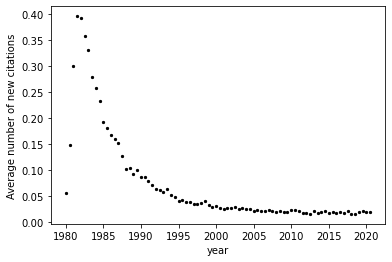

In [16]:
fig=plt.figure()

#プロットしたy軸とx軸を定義
y=df_analysis.values.tolist()
x=list(range(1980, 1980+len(y), 1))

x_new=[]
for i in x:
    x_new.append(1980+(i-1980)/2)

#対数プロットの場合
#plt.xscale('log')
#plt.yscale('log')

#範囲を指定
#plt.xlim(0.8, 100)
#plt.ylim(0.005, 2)

#グラフの種類
plt.scatter(x_new, y, s=5, c="black")

#ラベル
plt.xlabel("year")
plt.ylabel("Average number of new citations")

#グラフの保存
#fig.savefig("")

#グラフ描画
plt.show()

<ipython-input-22-9fb59a6dcd06>:16: RuntimeWarning: overflow encountered in exp
  return (N/(p+r-q)) * ((p-q)*np.exp(-(p+r)*x) + r*np.exp(-q*x))


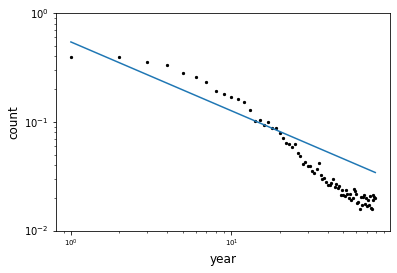

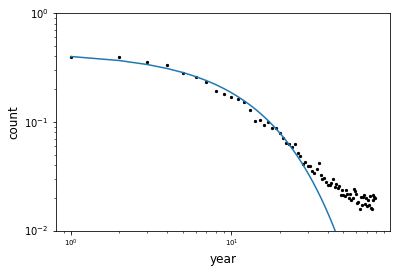

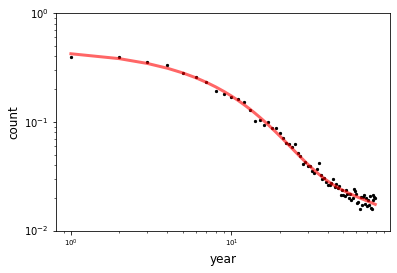

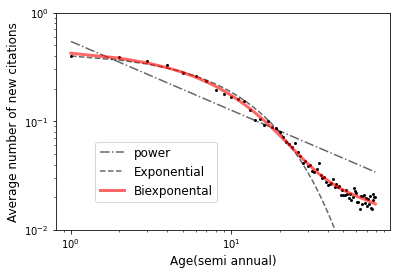

In [22]:
# 近似させる関数の定義
def beki(x, A, alpha):
    return A * x**(-alpha)

def exp(x, B, beta):
    return B * np.exp(-beta*x)

def taisu(x, sigma, m):
    pai=1/((2*np.pi)**0.5)
    first=1/(pai*sigma*x)
    second=(np.log(x)-m)**2
    third=2*(sigma**2)
    return first*np.exp(-second/third)

def soshisu(x, N, p, r, q):
    return (N/(p+r-q)) * ((p-q)*np.exp(-(p+r)*x) + r*np.exp(-q*x))


# 分析対象を定義
y_analysis=df_analysis.drop(df_analysis.index[[0,1,2]])#y(分析対象)(0~3行目を除いてる)
arr_1d = np.array(y_analysis.values.tolist())
x_analysis = np.linspace(1,len(arr_1d),len(arr_1d))#x(分析対象)


# 近似関数を求める
popt_beki, _ = optimize.curve_fit(beki, x_analysis, y_analysis)
popt_exp, _ = optimize.curve_fit(exp, x_analysis, y_analysis)
popt_taisu, _ = optimize.curve_fit(taisu, x_analysis, y_analysis)
popt_soshisu, _ = optimize.curve_fit(soshisu, x_analysis, y_analysis)


#べき
title = "bei_fitting_1980citations"
fig = plt.figure()
plt.scatter(x_analysis,y_analysis,marker='.',s=20, c="black")
plt.plot(x_analysis,beki(x_analysis,popt_beki[0],popt_beki[1]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("year",size=12)
plt.ylabel("count",size=12)
plt.ylim(0.01, 10)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=7)
#fig.savefig("")
plt.ylim(0.01,1)
plt.show()


#指数
title = "exp_fitting_1980citations"
fig=plt.figure()
plt.scatter(x_analysis,y_analysis,marker='.',s=20, c="black")
plt.plot(x_analysis,exp(x_analysis,popt_exp[0],popt_exp[1]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("year",size=12)
plt.ylabel("count",size=12)
plt.ylim(0.01, 10)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=7)
#fig.savefig("")
plt.ylim(0.01,1)
plt.show()

"""
#対数正規
title = "taisuseiki_fitting_1980citations"
fig=plt.figure()
plt.scatter(x_analysis,y_analysis,marker='.',s=20, c="black")
plt.plot(x_analysis,taisu(x_analysis,popt_taisu[0],popt_taisu[1]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("t(month)",size=12)
plt.ylabel("count",size=12)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=7)
fig.savefig("")
plt.show()
"""

#双指数
title = "biexp_fitting_1980citations"
fig=plt.figure()
plt.scatter(x_analysis,y_analysis,marker='.',s=20, c="black")
plt.plot(x_analysis,soshisu(x_analysis,popt_soshisu[0],popt_soshisu[1],popt_soshisu[2],popt_soshisu[3])
        ,linestyle = "solid", label = "Biexponental", color = "red", alpha = 0.6, linewidth = 3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("year",size=12)
plt.ylabel("count",size=12)
plt.ylim(0.0004, 0.8)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=7)
plt.ylim(0.01,1)
#fig.savefig("")
plt.show()

#まとめて(発表用)
title = "PRB1980citations_all_fitting"
fig=plt.figure()
plt.scatter(x_analysis,y_analysis,marker='.',s=15, c="black")
plt.plot(x_analysis,beki(x_analysis,popt_beki[0],popt_beki[1]),linestyle = "dashdot", label = "power", color = "black",alpha = 0.6)
plt.plot(x_analysis,exp(x_analysis,popt_exp[0],popt_exp[1]),linestyle = "dashed", label = "Exponential", color = "black",alpha = 0.6)
plt.plot(x_analysis,soshisu(x_analysis,popt_soshisu[0],popt_soshisu[1],popt_soshisu[2],popt_soshisu[3])
        ,linestyle = "solid", label = "Biexponental", color = "red", alpha = 0.6, linewidth = 3)
plt.legend(bbox_to_anchor=(0.1, 0.1), loc='lower left', borderaxespad=0.5, fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Age(semi annual)",size=12)
plt.ylabel("Average number of new citations",size=12)
#fig.savefig("")
plt.ylim(0.01,1)
plt.show()

In [23]:
r_beki = metrics.r2_score(y_analysis, beki(x_analysis, *popt_beki))#べきの決定係数(R2)を求める
r_exp = metrics.r2_score(y_analysis, exp(x_analysis, *popt_exp))#指数の決定係数(R2)を求める
r_taisu = metrics.r2_score(y_analysis, taisu(x_analysis, *popt_taisu))#対数正規の決定係数(R2)を求める
r_soshisu = metrics.r2_score(y_analysis, soshisu(x_analysis, *popt_soshisu))#対数正規の決定係数(R2)を求める

In [24]:
print(r_beki,r_exp,r_soshisu)

0.8482244908527621 0.9713996957519404 0.9954691719998425


In [25]:
print(popt_soshisu[0],popt_soshisu[1],popt_soshisu[2],popt_soshisu[3])

0.4686782199316096 0.10434498435526014 0.007015972662841814 0.007647425564652589


### 前処理の下書き ###

In [26]:
#まずPRLが6か月ごとに発行する論文数の推移を見る(UDLの補足資料の再現)。


volumes=list(range(1, 126, 1)) #フォルダが1～125まであるため手動で設定
papers_PRL=[]

for volume in volumes:
    
    files = glob.glob("aps_data/aps-dataset-metadata-2020/PRL/"+str(volume)+"/*")#PRBのフォルダリスト
    
    for file in files:
        json_open = open(file, "r",encoding="utf-8")
        json_load = json.load(json_open)
        papers_PRL.append(json_load["id"])
        #print(json_load["id"])
len(papers_PRL)

129116

In [27]:
#得られた論文リストについて、投稿年月日を半年ごとにカウントするdfを作成
df_PRL=df_ID_year[df_ID_year["id"].isin(papers_PRL)]
df_PRL=df_PRL.assign(count = [1] * len(df_PRL))#1の列を追加
df_PRL["year"] = pd.to_datetime(df_PRL["year"])
df_new = df_PRL.set_index('year')
df_new=df_new.drop(columns='id')
df_analysis=df_new.resample(rule="6MS").sum()
df_analysis.head()

,count
year,
1980-01-01,555
1980-07-01,647
1981-01-01,515
1981-07-01,580
1982-01-01,579


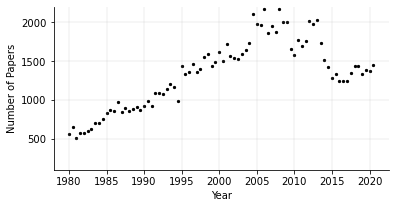

In [28]:
y=df_analysis["count"]#y(分析対象)
x=df_analysis.index#x(分析対象)
plt.figure(figsize=(6,3))
plt.scatter(x, y, s=5, c="black")
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.ylim(100, 2200)
plt.grid(linewidth=0.2)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

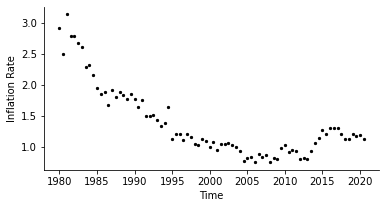

In [29]:
df_analysis["Inflation"]=df_analysis.loc['2000-01-01'][0]/df_analysis["count"]


y=df_analysis["Inflation"]#y(分析対象)
x=df_analysis.index#x(分析対象)
plt.figure(figsize=(6,3))
plt.scatter(x, y, s=5, c="black")
plt.xlabel('Time')
plt.ylabel('Inflation Rate')
#plt.ylim(100, 2200)
#plt.grid(linewidth=0.2)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

In [30]:
df_analysis.head()

,count,Inflation
year,,
1980-01-01,555,2.913514
1980-07-01,647,2.499227
1981-01-01,515,3.139806
1981-07-01,580,2.787931
1982-01-01,579,2.792746
